# Reproduction and Validation of a Scientific Paper
This Notebook presents the workflow and results of the exercise of the Experiment Design for Data Science course at TU Vienna. During this exercise the results of the paper "Carousel Personalization in Music Streaming Apps with Contextual Bandits" by by Benada et al. were reproduced and validated. The detailed description of the process and interpretations can be found in the accompanying report, which was released together with this report. 


In [2]:
# installations of required libraries
!pip install numpy
!pip install pandas
!pip install scipy
!pip install seaborn

In [12]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
sns.set_style(style='darkgrid')
plt.style.use('seaborn-darkgrid')

from scipy import stats
from scipy.stats import norm
from scipy.stats import f_oneway, wilcoxon

from main import *


In [8]:
# Helper Functions for statistical evaluation

def print_decision(pvalue, alpha):
    print("Test Result:")
    print("p-value = %.4f" % (pvalue))
    if pvalue < alpha:
        print("H0 can be rejected on a level of significance of " + str(alpha) + ".")
    else:
        print("H0 cannot be rejected on a level of significance of " + str(alpha) + ".")
        
def compute_pvalue(pvalue, diff, alternative):
    if alternative == "greater":
        if diff > 0:
            pvalue = pvalue / 2
        else:
            pvalue = 1 - pvalue / 2
    elif alternative == "less":
        if diff < 0:
            pvalue = pvalue / 2
        else:
            pvalue = 1 - pvalue / 2
    return pvalue

def plot_hist(data, group):
    # Plot a histogram
    plt.hist(data, density = True, alpha = 0.5)

    # Fit a normal distribution to the data
    mu, std = norm.fit(data)

    # Plot the probability density function
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 201)
    y = norm.pdf(x, mu, std)
    plt.plot(x, y, "black")
    title = "Fit results of " + group + ": mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)


# Reproduction
## Experiment 1
Overall the paper release their code and their data in a public repository: https://github.com/deezer/carousel_bandits  The paper consits of an offline and online experiment. There was no way for us to reproduce the offline experiment. Thus we focused our effort on the offline experiments. The paper in itself doesn't show many results. The major one being that a certain algorithm of the multiarmed bandit outperforms all the other ones, which were tested. 

### Showing that the provided Code runs
The following chunk runs a lightweight version of the experiment once, with only a handful of users.
At each round, the model gets fitted to every user in the dataset and a regret score is calculated.
At the end of all rounds (by default 100 rounds) the minimum cumulative regret indicates, which model performs best.
According to the source paper, *ts-seg-pessimistic* performs best on the offline experiment. Hence, they tested this models performance in a cascade versus non-cascade offline experiment, in which case the *ts-seg-pessimistic cascade* model performed best. This model also caused the highest display-to-stream gain.
All featured tests' results showed statistical significance at the 1% level. However, the paper does not state how those statistical tests were conducted.

In [ ]:
# uncomment the following lines to run the experiment with the small dataset and all policies
# !python main.py --users_path data/user_features_small.csv --policies random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic --n_users_per_round 9 --output_path general_experiment_results.json
# !python plot_results.py --data_path general_experiment_results.json


In [ ]:
# uncomment the following lines to run the experiment with the full dataset and only two policies

# !python main.py --policies random,ts-seg-pessimistic --print_every 5 --output_path general_experiment_results.json
# !python plot_results.py --data_path general_experiment_results.json

### Issues

One major issue with the provided code which was found is that in each round the algorithm is trained on 20000 randomly selected users. Thus, depending on what users each algorithm sees in what round it should have lead to different regret values. The paper doesn't set a seed for the sampling, which is understanble as it would lead to always the same sampling of users and not take advantage of the whole dataset. This is the major issue with the methodolgy, which will be explored in this notebook.

### Reproduction on the Whole Dataset
To visulalize and explore the variability of the workflow introduced by the user selection we repeated the whole offline experiment 5 seperate times and stored the corresponding results. It has to be noted at this point that running the training of all policies on the whole dataset (still with 20000 useres per round) takes approximatley 5 hours on our machine. Thus we were satisfied by having a sample size of 5.


In [9]:
# experiment setup
users_path = "data/user_features.csv"
users_df = pd.read_csv(users_path)

playlists_path = "data/playlist_features.csv"
playlists_df = pd.read_csv(playlists_path)

n_users = len(users_df)
n_playlists = len(playlists_df)
n_recos = 12
print_every = 10

user_features = np.array(users_df.drop(["segment"], axis = 1))
user_features = np.concatenate([user_features, np.ones((n_users,1))], axis = 1)
playlist_features = np.array(playlists_df)

user_segment = np.array(users_df.segment)

policies_name = "random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic".split(",")
policies = set_policies(policies_name, user_segment, user_features, n_playlists)
n_policies = len(policies)

n_users_per_round = 20000
n_rounds = 100
overall_rewards = np.zeros((n_policies, n_rounds))
overall_optimal_reward = np.zeros(n_rounds)

l_init = 3
n_recos = 12


In [ ]:
#running this junk will approximately take 30 hours
for k in range(5):
    print("Run: %d"%(k))
    cont_env = ContextualEnvironment(user_features, playlist_features, user_segment, n_recos)    
    start_time = time.time()
    for i in range(n_rounds):
        # Select batch of n_users_per_round users
        user_ids = np.random.choice(range(n_users), n_users_per_round)
        overall_optimal_reward[i] = np.take(cont_env.th_rewards, user_ids).sum()
        # Iterate over all policies
        for j in range(n_policies):
            # Compute n_recos recommendations
            recos = policies[j].recommend_to_users_batch(user_ids, n_recos, l_init)
            # Compute rewards
            rewards = cont_env.simulate_batch_users_reward(batch_user_ids= user_ids, batch_recos=recos)
            # Update policy based on rewards
            policies[j].update_policy(user_ids, recos, rewards, l_init)
            overall_rewards[j,i] = rewards.sum()
        # Print info
        if i == 0 or (i+1) % print_every == 0 or i+1 == n_rounds:
            print("Round: %d/%d. Elapsed time: %f sec." % (i+1, n_rounds, time.time() - start_time))

    output_path = 'reproducibility_exp/completly_new/results_%d.json'%(k)
    print("Saving cumulative regrets in %s" % output_path)
    cumulative_regrets = {policies_name[j] : list(np.cumsum(overall_optimal_reward - overall_rewards[j])) for j in range(n_policies)}
    with open(output_path, 'w') as fp:
        json.dump(cumulative_regrets, fp)

In [15]:
# Processing the reulst for the experiments
all ={}
mean ={}
std = {}
last_round ={}
data_path = 'reproducibility_exp/completly_new/results_0.json'

with open(data_path, 'r') as fp:
    cumulative_regrets = json.load(fp)
for k,v in cumulative_regrets.items():
    all[k] = list()
    mean[k] = list()
    std[k] = list()
    last_round[k] = list()

for k in range(5):
    output_path = 'reproducibility_exp/completly_new/results_%d.json'%(k)
    #if k!=2:
    with open(output_path, 'r') as fp:
        cumulative_regrets = json.load(fp)
        for k,v in cumulative_regrets.items():
            all[k].append(np.array(v))


In [16]:
for i in all.keys():
    for j in range(len(all[i][0])):
        intermediate = list()
        for k in range(len(all[i])):
            intermediate.append(all[i][k][j])

        mean[i].append(np.mean(intermediate))
        std[i].append(np.std(intermediate))

for i in all.keys():
    for j in range(len(all[i])):
        last_round[i].append(all[i][j][-1])

NameError: name 'mean' is not defined

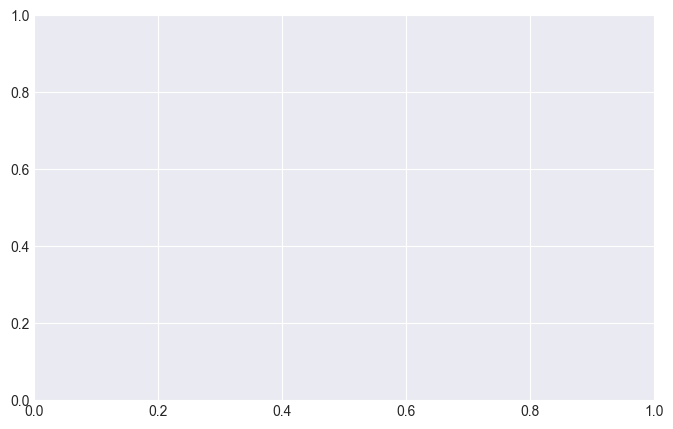

In [10]:
# Visulaizing the Cumulative Results
pos_col = mcolors.TABLEAU_COLORS.keys()

fig, ax = plt.subplots(figsize=(8,5))
for i in range(len(mean.keys())):
    sns.lineplot(data = np.array(mean[list(mean.keys())[i]]), label = list(mean.keys())[i], color=list(pos_col)[i])
    plt.fill_between(range(len(mean[list(mean.keys())[i]])), np.array(mean[list(mean.keys())[i]])-np.array(std[list(mean.keys())[i]]), np.array(mean[list(mean.keys())[i]])+np.array(std[list(mean.keys())[i]]), alpha =0.30, color=list(pos_col)[i])
ax.ticklabel_format(style='plain')
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.show()

The plot above shows the obtained results. The line represent the mean regret obtained over the five itereations and the variablity is shown as filled space around the mean according to the standard deviation. One fairly obvious conclusion is that the illustration looks almost identical to the original graphic in the paper. Additionally we seee that in almost all algorihtms are fairly robust with regards to the users it is trained on. Maybe this is because of the large sample size in each round and the default value taken in the paper represents a hypertuned one, which balances well the robustness and computational performance. Only the 'ts-lin-naive' approach seems to show visible variablilty. In all other cases the standard deviation too small to be visible on the presenetd scale.

### Statistical Testing

The conclusion from the paper is that the 'ts-seg-pessimistic' policy outperforms all other ones and says it does so with a siginificance niveau of 0.01. However, they don't specify the test they use or what data they used for the test. Thus we further explored the results using different statistical tests and different data. More specifically for the test statistic either the whole data of all 5 iterations was used or simply the information in the last round as this resembles the final model, which will be used in production.

Since we have a relative small sample size we stuck with non-parametric tests and in a first step used a Friedman test to confirm that at least one location parameter all policies is different to all others. This procedure was prefered to use a two-sample test on all possible combinations as it limits the probailiy of a type 1 error. The Friedman test is a non-parametric test alternative to the repeaeted ANOVA test. It uses the following hypothesis, with n being at least 3:

$H_0: \mu_1 = \mu_2 = ... = \mu_n$


$H_1: \exists i,j \leq n: \mu_i \neq \mu_j$ 


In [52]:
friedmann_df = pd.DataFrame(columns=['p-Value'], index=['All', 'Last Round'])

In [54]:
# Friedman Test on the whole training data 
alpha = 0.01
res = stats.friedmanchisquare(all[policies_name[0]], all[policies_name[1]], all[policies_name[2]], all[policies_name[3]], all[policies_name[4]], all[policies_name[5]], all[policies_name[6]], all[policies_name[7]], all[policies_name[8]], all[policies_name[9]])
print_decision(res.pvalue, alpha)

friedmann_df['p-Value']['All']=res.pvalue

Test Result:
p-value = 0.0000
H0 can be rejected on a level of significance of 0.01.


In [56]:
#using only the data from the last round
res = stats.friedmanchisquare(last_round[policies_name[0]], last_round[policies_name[1]], last_round[policies_name[2]], last_round[policies_name[3]], last_round[policies_name[4]], last_round[policies_name[5]], last_round[policies_name[6]], last_round[policies_name[7]], last_round[policies_name[8]], last_round[policies_name[9]])
print_decision(res.pvalue, alpha)

friedmann_df['p-Value']['Last Round']=res.pvalue

Test Result:
p-value = 0.0000
H0 can be rejected on a level of significance of 0.01.


To no suprise in both cases we can frimly reject the null hypothesis, which shows us that there is a significant difference in the results of the policies. Since, the paper claims that the policy 'ts-seg-pessimistic' is significantly better than all other ones, we performed statistical tests to confirm that. We used a Mann-Whitney-U test, since we compare the distributions of independent samples. In order to confirm the statemant that the policy is truly better than all other ones we perform a one sided test with the follwing Hypothesis:

$H_0: \mu_A \geq \mu_B$ 

$H_1: \mu_A < \mu_B$ (```alternative = "less"```)

Thus in the case the assumption of the paper is correct we can always reject the null hypothesis.

In [80]:
iterables = [["All", "Last Round"], policies_name]
m_index = pd.MultiIndex.from_product(iterables, names=["Data", "Policy"])

mwu_df = pd.DataFrame(columns=['p-Value'], index = m_index)
mwu_df.drop('ts-seg-pessimistic', level=1, inplace=True)

In [81]:
#on all the data
for i in policies_name:
    if i != 'ts-seg-pessimistic':
        res = stats.mannwhitneyu(np.array(all['ts-seg-pessimistic']).flatten(), np.array(all[i]).flatten(), alternative = 'less')
        mwu_df.loc[('All',i)]=res.pvalue
        if res.pvalue > alpha:
            print_decision(res.pvalue, alpha)
        else:
            print("Comparing ts-seg-pessimistic to %s result: H0 rejected"%(i))


Comparing ts-seg-pessimistic to random result: H0 rejected
Comparing ts-seg-pessimistic to etc-seg-explore result: H0 rejected
Comparing ts-seg-pessimistic to etc-seg-exploit result: H0 rejected
Comparing ts-seg-pessimistic to epsilon-greedy-explore result: H0 rejected
Comparing ts-seg-pessimistic to epsilon-greedy-exploit result: H0 rejected
Comparing ts-seg-pessimistic to kl-ucb-seg result: H0 rejected
Comparing ts-seg-pessimistic to ts-seg-naive result: H0 rejected
Comparing ts-seg-pessimistic to ts-lin-naive result: H0 rejected
Comparing ts-seg-pessimistic to ts-lin-pessimistic result: H0 rejected


In [82]:
#on just the last round
for i in policies_name:
    if i != 'ts-seg-pessimistic':
        res = stats.mannwhitneyu(last_round['ts-seg-pessimistic'], last_round[i], alternative = 'less')
        mwu_df.loc[('Last Round',i)]=res.pvalue
        
        if res.pvalue > alpha:
            print_decision(res.pvalue, alpha)
        else:
            print("Comparing ts-seg-pessimistic to %s result: H0 rejected"%(i))
        

Comparing ts-seg-pessimistic to random result: H0 rejected
Comparing ts-seg-pessimistic to etc-seg-explore result: H0 rejected
Comparing ts-seg-pessimistic to etc-seg-exploit result: H0 rejected
Comparing ts-seg-pessimistic to epsilon-greedy-explore result: H0 rejected
Comparing ts-seg-pessimistic to epsilon-greedy-exploit result: H0 rejected
Comparing ts-seg-pessimistic to kl-ucb-seg result: H0 rejected
Comparing ts-seg-pessimistic to ts-seg-naive result: H0 rejected
Comparing ts-seg-pessimistic to ts-lin-naive result: H0 rejected
Comparing ts-seg-pessimistic to ts-lin-pessimistic result: H0 rejected


In [85]:
mwu_df

p-Value
Data       Policy                          
All        random                       0.0
           etc-seg-explore              0.0
           etc-seg-exploit              0.0
           epsilon-greedy-explore       0.0
           epsilon-greedy-exploit       0.0
           kl-ucb-seg                   0.0
           ts-seg-naive                 0.0
           ts-lin-naive                 0.0
           ts-lin-pessimistic           0.0
Last Round random                  0.003968
           etc-seg-explore         0.003968
           etc-seg-exploit         0.003968
           epsilon-greedy-explore  0.003968
           epsilon-greedy-exploit  0.003968
           kl-ucb-seg              0.003968
           ts-seg-naive            0.003968
           ts-lin-naive            0.003968
           ts-lin-pessimistic      0.003968

In both cases the H0 hypothesis is rejected which statistically confirms the claims of the paper.

## Experiment 2

We can reproduce the full offline experiment. We just need to find a way to compare results.
We will perform two separate experiments, mirroring the two offline experiments outlined in the paper. On both we will run 100 rounds of consecutive multi-armed-bandit recommendation cycles, using different policies each time.
The following parameters will make out the two experiments:
* first we run all policies to determine which policies generally perform best
* we then rerun the experiment with the two best-performing policies, comparing whether cascading improves model performance

On each experiment, the steps are:
1. Run the experiment for 100 rounds, on each round make `n` (number of users) predictions with `p` (number of models) and save the cumulative regret in a JSON file. That process gets repeated `k` (number of samples for the experiment) times.
2. Run an ANOVA test on the policies cumulative regrets of the final round to determine if there is a statistical difference in their means.
3. Run a one-sided t-test to determine if the best-performing policy is statistically better than the next best policy model.
4. Compare the results with the results of the paper.


## Does the original code cross-validate?
No, but something different. The argument *n_users_per_round* (default 20.000, 1% of full dataset) states, how many users actually get recommended anything in any round. That means that the actual dataset never changes for every time you run the experiment, but the sample on which you fit and evaluate the model changes on every round.
According to Brownlee (2018, https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/), this testing behaviour violates a key assumption of the Student's t-test, which is independency of observations in each sample per round.
Our suggestion for fixing this: Run the full experiment k (10) times and give the program either 10% of the data to work on, while either continuing to let it use a sample of 20.000 users or even telling it not to resample anything, but rather work on the whole data. Instead of rewriting the source code to include cross-validation, we will split the users dataset itself into k samples and run the whole main.py file k times, with different arguments each time, i.e. changing the results-output-filename.
The only rewriting we will do, is putting the main workflow of the main.py file into a separate main() function with arguments passed in python rather than from the command line, so we can execute it using this notebook.


In [13]:
from experiment import run_experiment

# test run of the new experiment.py
run_exemplary_experiment = False

if run_exemplary_experiment:
        #users_path: path to the user input data (sample)
        #playlists_path: path to the playlist feature input data (full dataset, not sampled)
        #output_path: desired location of the evaluation metrics output
        #policices: comma separated string of all policies you want the program to run

        #The following parameters were used by the original authors:
        #n_recos: number of recommendations per user per round
        #l_init: number of recommendations the user sees without scrolling
        #n_users_per_round: how many users to make recommendations for per round. The authors used 20_000. Setting it to None will make the experiment use all users, eliminating some variance in the results
        #n_rounds: number of consecutive rounds. Regret gets lower per round for all policies except for "random"
        #print_every: how often you want the current results to be printed; the first and last results get printed anyway
        run_experiment(
                users_path="data/user_features.csv",
                playlists_path="data/playlist_features.csv",
                output_path="results.json",
                policies="random,ts-seg-naive",
                n_recos=12,
                l_init=3,
                n_users_per_round=20000,
                n_rounds=100,
                print_every=10,
        )

In [15]:
def split_dataset(input_path, output_path="data/split", k=10):
        """
        grabs a datafile from the folder "data/"
        randomly splits the dataset into k smaller sets of equal size
        saves them in the folder "data/split/"
        """

        with open(f"{input_path}", "r") as f:
                full = np.array(f.readlines())

        data_filename, suffix = input_path.split(".")

        # header row should be separate
        header_row, full = full[0], full[0:]

        N = len(full) # number of all rows
        indices = np.array(list((range(N)))) # numbers from 0 to N
        n = N // k # number of rows per k

        print(f"Splitting {N} rows from {data_filename}.{suffix} into {k} files with {n} rows each ...")

        for i in range(k):
                # get random row numbers from 0 to the length of indices (starts at N)
                random_indices = np.random.choice(len(indices), n, replace=False)
                # grab random row numbers of the remaining ones
                sample_indices = indices[random_indices]
                # remove the selected row numbers from the indices list
                indices = np.delete(indices, random_indices)
                # create a sample
                sample = full[sample_indices]
                # add the header row
                sample = np.append(header_row, sample)
                # save the sample
                print(f"\t saving file number {i}: {sample_indices}")
                f = f"{output_path}/{data_filename}_{i}.{suffix}"
                with open(f, "w") as f:
                        f.writelines(list(sample))


        print(f"All done. {len(indices)} users remain unsaved: {indices}")
        print()
        del full
        del indices
        del sample




# Preparing k datasets
data_filename = "user_features.csv"
data_filename = "user_features_s.csv"

k = 10
# uncomment the following line to enable the data splitting
#split_dataset(data_filename, "data/splitS", k)

### Data for testing
We randomly sampled a 10th of the original data to account for computing time.  Differently sized groups of samples are found in these locations (given the chunk that splits the datasets is executed):
* data/samplesS/: 8 samples of ~10.000 rows each
* data/samplesL/: 8 larger samples of ~100.000 samples each

In [16]:
from experiment import run_experiment
all_policies = "random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic"

def run_k_experiments(
        input_samples_dir,
        output_dir="output",
        n_users_per_round=None,
        print_every=5,
        policies=all_policies
):
        """
        Performs the experiment on a given number of user data and saves the outputs in a folder for later analysis.
        input_samples_dir: directory where samples are located
        output_dir: desired output location for the JSON files containing the cumulative regret
        n_users_per_round: number of users to make recommendations for on each round. None -> all users
        print_every: how often you want to see current results. first and last round get printed anyway
        policies: comma-separated string of policies to use
        """
        input_samples_dir = input_samples_dir.strip("/")
        output_dir = output_dir.strip("/")

        files = os.listdir(input_samples_dir)
        print(f"Running {len(files)} experiments with input files from {input_samples_dir}")
        for f in files:
                try:
                        run_experiment(
                                users_path=f"{input_samples_dir}/{f}",
                                playlists_path="data/playlist_features.csv",
                                output_path=f"{output_dir}/results_{f}.json",
                                policies=policies,
                                n_recos=12,
                                l_init=3,
                                n_users_per_round=n_users_per_round,
                                n_rounds=100,
                                print_every=print_every,
                        )
                except TypeError as e:
                        print(f"Experiment failed on input file {f}", e)
                except KeyError as e:
                        print(f"Experiment failed on input file {f}", e)
        print("Experiments finished.")


In [17]:
## Loading results (cumulative regret)
def get_results(results_location, wide=True, long=False):
        """
        loads the results from one or many JSON file
        results_location: path to the folder of the JSON files
        the results of each file's lat round get loaded into a column per policy wide format, each row being a sample
        wide_to_long: whether the resulting dataframe should be put in long format -> one column "policy" for the policies and one column "regret" for the results
        """
        results = None
        for f in [f for f in os.listdir(results_location) if "store" not in f.lower()]:
                with open(f"{results_location}/{f}", "r") as f:
                        res = json.load(f)
                res = {key: [value[-1]] for key, value in res.items()}
                res = pd.DataFrame.from_dict(res)
                if results is None:
                        results = res
                else:
                        results = results.append(res)

        results = results.reset_index().drop("index", 1)

        if long:
                results_long = results.unstack().reset_index()
                results_long = results_long.drop("level_1", 1)
                results_long.columns = ["policy", "regret"]
                if wide:
                        return results, results_long
                else:
                        return results_long
        return results


In [18]:
def test_distribution_difference(data, alpha=.05):
        # performs a one-sided ANOVA test on all of the input data's columns
        # the input data should be in wide_format
        # -> one column per policy & one row per sample
        result = f_oneway(*(data[col] for col in data.columns))
        print("Test result", result)
        p = result[1]
        significant = p < alpha
        if significant:
                print("Reject the Null-Hypothesis")
                print("—> The policies' cumulative regret distributions do not have equal means.")
        else:
                print("Keep the Null-Hypothesis")
                print("—> The policies' cumulative regret distributions have equal means.")


In [19]:
def test_wilcoxon(x, y, x_name="X", y_name="Y"):

        print("Wilcoxon Test")
        print(f"Comparing two samples with means:")
        print(f"{x_name}: {x.mean()} ==== {y_name}: {y.mean()}")

        stat, p = wilcoxon(x, y, alternative="less")
        print(f"p-value: {p}")
        alpha = .05
        significant = p < alpha
        print("—>", "reject H0" if significant else "accept H0")
        print("—>", f"The cumulative regret of {x_name} is significantly smaller the the cumulative regret of {y_name}"
                if significant
                else f"Cannot prove the cumulative regret of {x_name} being significantly smaller the the cumulative regret of {y_name}")


## Experiment 2.1
Running all policies on all users and seeing which policy performs best
We run this on 10 samples of the original data. Each sample contains 1000 users/rows.

In [20]:
input_samples_dir = "data/samplesS"
output_dir = "data/t"
n_users_per_round = None

run_experiment_1 = False # set this flag to True if you want to rerun experiment 1

if run_experiment_1:
        run_k_experiments(input_samples_dir, output_dir, n_users_per_round)

### Checkin on the results


In [23]:
results_location = "output/s1"
ex1_wide, ex1_long = get_results(results_location, long=True)
print("The first experiment's resulting cumulative regret metrics")
ex1_wide

The first experiment's resulting cumulative regret metrics


,random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic
0,635810.432176,600168.432176,200190.432176,153611.432176,180213.432176,361821.432176,183269.432176,110979.432176,172816.432176,179614.432176
1,637668.255530,606246.255530,203604.255530,153131.255530,176513.255530,365022.255530,183273.255530,112362.255530,176445.255530,185467.255530
2,636382.800701,605270.800701,200441.800701,151974.800701,207033.800701,361327.800701,181519.800701,109120.800701,175299.800701,185098.800701
3,637826.240031,605148.240031,201080.240031,149822.240031,175865.240031,359257.240031,181628.240031,112390.240031,182412.240031,176364.240031
4,637504.583938,606253.583938,200677.583938,156294.583938,177888.583938,361673.583938,182329.583938,112305.583938,184599.583938,177615.583938
5,635408.688322,603800.688322,199123.688322,156148.688322,183994.688322,357021.688322,183558.688322,108956.688322,180716.688322,179266.688322
6,637127.775000,601849.775000,201858.775000,157303.775000,168204.775000,363928.775000,181134.775000,107095.775000,177519.775000,170165.775000
7,639748.180559,606201.180559,201553.180559,152835.180559,173679.180559,358169.180559,181350.180559,110466.180559,174629.180559,171064.180559


The mean cumulative regret of each policy in the first experiment
                               regret
policy                               
ts-seg-pessimistic      110459.619532
epsilon-greedy-explore  153890.244532
ts-lin-naive            178054.869532
ts-lin-pessimistic      178082.119532
epsilon-greedy-exploit  180424.119532
ts-seg-naive            182257.994532
etc-seg-exploit         201066.244532
kl-ucb-seg              361027.744532
etc-seg-explore         604367.369532
random                  637184.619532


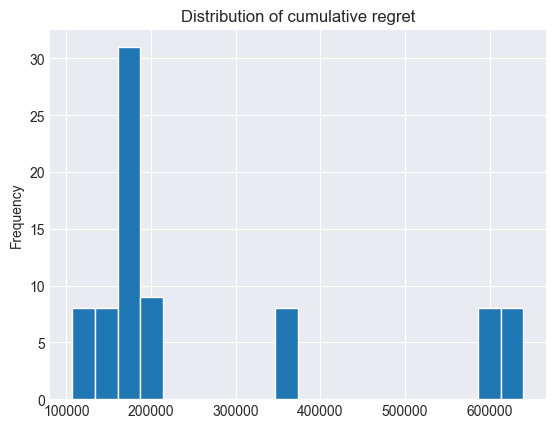

In [24]:
ex1_long.regret.plot(kind='hist', title='Distribution of cumulative regret', bins=20)
results_mean = ex1_long.groupby("policy").mean().sort_values("regret")
print("The mean cumulative regret of each policy in the first experiment")
print(results_mean)

### ANOVA: are means generally different?
H0: each policy's cumulative regret is the same
H1: the policies' cumulative regrets have different distributions

In [25]:
test_distribution_difference(ex1_wide, alpha=0.01)
print()
print()
print("The random policy will always on average have approximately constant regret as rounds go on. Therefore we rerun this test excluding this least-performing policy:")
print()
test_distribution_difference(ex1_wide.drop("random", 1), alpha=0.01)

Test result F_onewayResult(statistic=13786.875134009646, pvalue=5.2725030528860614e-110)
Reject the Null-Hypothesis
—> The policies' cumulative regret distributions do not have equal means.


The random policy will always on average have approximately constant regret as rounds go on. Therefore we rerun this test excluding this least-performing policy:

Test result F_onewayResult(statistic=7996.810784099319, pvalue=1.1800508056294417e-91)
Reject the Null-Hypothesis
—> The policies' cumulative regret distributions do not have equal means.


### Is the best policy statistically outperforming the other's?

In [26]:
top_policy = results_mean.iloc[0]
second_best_policy = results_mean.iloc[1]
global_mean = results_mean.mean()

print("Best performing policy:", top_policy.name, "->", top_policy[0])
print("Second best performing policy:", second_best_policy.name, "->", second_best_policy[0])
print("Global mean regret:", global_mean[0])


Best performing policy: ts-seg-pessimistic -> 110459.61953232295
Second best performing policy: epsilon-greedy-explore -> 153890.24453232298
Global mean regret: 278681.494532323


Just like in the authors' experiment, the best performin policy is Pessimistic Thomson Sampling with clusters (`ts-seg-pessimistic`). Now, to test whether this policy is better than the second best performing policy (in our case`epsilon-greedy-explore`), we will conduct a statistical test of their difference.
A parametric test would have certain conditions:
* The population distributions are approximately normally distributed
* The samples are independent

Since we cannot confirm a normal distribution we will resort to a non-parametric test, namely the Wilcoxon ranked test.

In [27]:
#test_wilcoxon
x = ex1_wide["ts-seg-pessimistic"]
y = ex1_wide["epsilon-greedy-explore"]
test_wilcoxon(x, y, "ts-seg-pessimistic", "epsilon-greedy-explore")

Wilcoxon Test
Comparing two samples with means:
ts-seg-pessimistic: 110459.61953232295 ==== epsilon-greedy-explore: 153890.24453232298
p-value: 0.00390625
—> reject H0
—> The cumulative regret of ts-seg-pessimistic is significantly smaller the the cumulative regret of epsilon-greedy-explore


## Experiment 2.2
Finding out whether cascading makes the models better

Original command:
`python main.py --policies epsilon-greedy-explore,epsilon-greedy-explore-no-cascade,ts-seg-pessimistic,ts-seg-pessimistic-no-cascade --print_every 5 --output_path cascade_experiment_results.json`
`python plot_results.py --data_path cascade_experiment_results.json`

In [28]:
input_samples_dir = "data/samplesS"
output_dir = "output/casc"
n_users_per_round = None
policies = "epsilon-greedy-explore,epsilon-greedy-explore-no-cascade,ts-seg-pessimistic,ts-seg-pessimistic-no-cascade"

run_experiment_flag = False

if run_experiment_flag:
    run_k_experiments(input_samples_dir, output_dir, n_users_per_round, policies=policies)


In [29]:
results_location = "output/casc"
ex2_wide, ex2_long = get_results(results_location, long=True)
print("The second experiment's resulting cumulative regret metrics")
ex1_wide

The second experiment's resulting cumulative regret metrics


,random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic
0,635810.432176,600168.432176,200190.432176,153611.432176,180213.432176,361821.432176,183269.432176,110979.432176,172816.432176,179614.432176
1,637668.255530,606246.255530,203604.255530,153131.255530,176513.255530,365022.255530,183273.255530,112362.255530,176445.255530,185467.255530
2,636382.800701,605270.800701,200441.800701,151974.800701,207033.800701,361327.800701,181519.800701,109120.800701,175299.800701,185098.800701
3,637826.240031,605148.240031,201080.240031,149822.240031,175865.240031,359257.240031,181628.240031,112390.240031,182412.240031,176364.240031
4,637504.583938,606253.583938,200677.583938,156294.583938,177888.583938,361673.583938,182329.583938,112305.583938,184599.583938,177615.583938
5,635408.688322,603800.688322,199123.688322,156148.688322,183994.688322,357021.688322,183558.688322,108956.688322,180716.688322,179266.688322
6,637127.775000,601849.775000,201858.775000,157303.775000,168204.775000,363928.775000,181134.775000,107095.775000,177519.775000,170165.775000
7,639748.180559,606201.180559,201553.180559,152835.180559,173679.180559,358169.180559,181350.180559,110466.180559,174629.180559,171064.180559


In [30]:
print("Experiment 2 mean cumulative regret")
ex2_wide.mean().sort_values()

Experiment 2 mean cumulative regret


ts-seg-pessimistic                   110525.745906
ts-seg-pessimistic-no-cascade        129207.245906
epsilon-greedy-explore               150814.245906
epsilon-greedy-explore-no-cascade    154436.495906
dtype: float64

For both of the two top policies, the cascading strategy improves the results, just as the original authors stated.
We now perform another statistical test to prove their differences' significance.

In [31]:
x = ex2_wide["ts-seg-pessimistic"]
y = ex2_wide["ts-seg-pessimistic-no-cascade"]
test_wilcoxon(x, y, "ts-seg-pessimistic", "ts-seg-pessimistic-no-cascade")
print()
print()
x = ex2_wide["epsilon-greedy-explore"]
y = ex2_wide["epsilon-greedy-explore-no-cascade"]
test_wilcoxon(x, y ,"epsilon-greedy-explore", "epsilon-greedy-explore-no-cascade")


Wilcoxon Test
Comparing two samples with means:
ts-seg-pessimistic: 110525.74590614034 ==== ts-seg-pessimistic-no-cascade: 129207.24590614034
p-value: 0.00390625
—> reject H0
—> The cumulative regret of ts-seg-pessimistic is significantly smaller the the cumulative regret of ts-seg-pessimistic-no-cascade


Wilcoxon Test
Comparing two samples with means:
epsilon-greedy-explore: 150814.2459061404 ==== epsilon-greedy-explore-no-cascade: 154436.49590614036
p-value: 0.0546875
—> accept H0
—> Cannot prove the cumulative regret of epsilon-greedy-explore being significantly smaller the the cumulative regret of epsilon-greedy-explore-no-cascade


In our own test we can confirm that the cascading approach improves the performance of the `ts-seg-pessimistic` policy. We could not, however, prove that cascading improves the performance of the second best policy, `epsilon-greedy-explore`.

## Sources:
Python for Data Science (2020): INDEPENDENT T-TEST. https://www.pythonfordatascience.org/independent-samples-t-test-python/